## Supervised Learning
## Project: Finding Donors for *CharityML*

## Introduction

This is the first project of Udacity Data Scientist Nanodegree Program which is composed by:
- Supervised Learning
- Deep Learning
- Unsupervised Learning

The goal of this project is to put in action all the information provided during the Supervised Learning part of the course.

CharityML is a fictitious charity organization located in the heart of Silicon Valley that was established to provide financial support for people eager to learn machine learning. After nearly 32,000 letters were sent to people in the community, CharityML determined that every donation they received came from someone that was making more than $50,000 annually. To expand their potential donor base, CharityML has decided to send letters to residents of California, but to only those most likely to donate to the charity. With nearly 15 million working Californians, CharityML has brought us on board to help build an algorithm to best identify potential donors and reduce overhead cost of sending mail. Our goal will be evaluate and optimize several different supervised learners to determine which algorithm will provide the highest donation yield while also reducing the total number of letters being sent.

To summarize our goal is to accurately model individuals' income using data collected from the 1994 U.S. Census in order to predicts whether an individual makes more than $50,000. 
This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with. While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the [article](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf) _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

### Software and Libraries
This project uses Python 3.10.4 the following libraries:
- NumPy
- pandas
- scikit-learn
- Matplotlib
- seaborn

More informations in `requirements.txt`.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import seaborn as sns
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
from sklearn.metrics import confusion_matrix


import utils.configuration as conf
import utils.visuals as vs


# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv(conf.DATA_FOLDER + "census.csv")

# Display the first 10 records
display(data.head(n=10))

Folder 'data/' already exists.
Folder 'images/' already exists.


,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K
5,37,Private,Masters,14.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0,United-States,<=50K
6,49,Private,9th,5.0,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.0,0.0,16.0,Jamaica,<=50K
7,52,Self-emp-not-inc,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,45.0,United-States,>50K
8,31,Private,Masters,14.0,Never-married,Prof-specialty,Not-in-family,White,Female,14084.0,0.0,50.0,United-States,>50K
9,42,Private,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178.0,0.0,40.0,United-States,>50K


A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. From the above table we can see that the `'income'` entries are labelled as `>50K` if a person makes more than \$50,000 and `<=50K` otherwise. 

In [2]:
# Total number of records
n_records = data.shape[0]
 
# Number of records where individual's income is more than $50,000 annually
greater_50k = data[data['income'] == ">50K"]
#display(greater_50k.head(n=10))
n_greater_50k = greater_50k.shape[0]

# Number of records where individual's income is at most $50,000 annually
at_most_50k = data[data['income'] == "<=50K"]
#display(at_most_50k.head(n=10))
n_at_most_50k = at_most_50k.shape[0]

# Percentage of individuals whose income is more than $50,000 annually
greater_percent = (n_greater_50k/n_records) * 100

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000 annually: {}".format(n_greater_50k))
print("Individuals making at most $50,000 annually: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000 annually: {:.2f}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000 annually: 11208
Individuals making at most $50,000 annually: 34014
Percentage of individuals making more than $50,000 annually: 24.78%


As we can see from the preliminary analysis our dataset is unbalanced because of course most individuals do not make more than $50,000 thus as we will better explain in the **Naive Predictor** section this can have an impact on the accuracy of the model we are going to develop.

### Featureset Exploration

It is also usefull to see the datatype of the features:

In [3]:
#Checking out the datatypes of the features
data.info()

print("\n----------\nCategorical variables values:")
#List values for categorical variables
for name, values in data.items():
	if(values.dtype != np.float64 and values.dtype != np.int64):
		print('{name}: {value}\n'.format(name=name, value=values.unique()))
	else:
		pass

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              45222 non-null  int64  
 1   workclass        45222 non-null  object 
 2   education_level  45222 non-null  object 
 3   education-num    45222 non-null  float64
 4   marital-status   45222 non-null  object 
 5   occupation       45222 non-null  object 
 6   relationship     45222 non-null  object 
 7   race             45222 non-null  object 
 8   sex              45222 non-null  object 
 9   capital-gain     45222 non-null  float64
 10  capital-loss     45222 non-null  float64
 11  hours-per-week   45222 non-null  float64
 12  native-country   45222 non-null  object 
 13  income           45222 non-null  object 
dtypes: float64(4), int64(1), object(9)
memory usage: 4.8+ MB

----------
Categorical variables values:
workclass: [' State-gov' ' Self-emp-not-inc' ' Priv

To summarize the features are:
* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education_level**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.
* **income**: >50K, <=50K. 

Using [`seaborn.catplot`](https://seaborn.pydata.org/generated/seaborn.catplot.html) we can use several axes-level plot to better undertand the relationship between a numerical variables and one or more categorical variables.
In our case we could use:
- `income` as x
- `capital-gain` as y
- `sex` as hue
- `race` in column

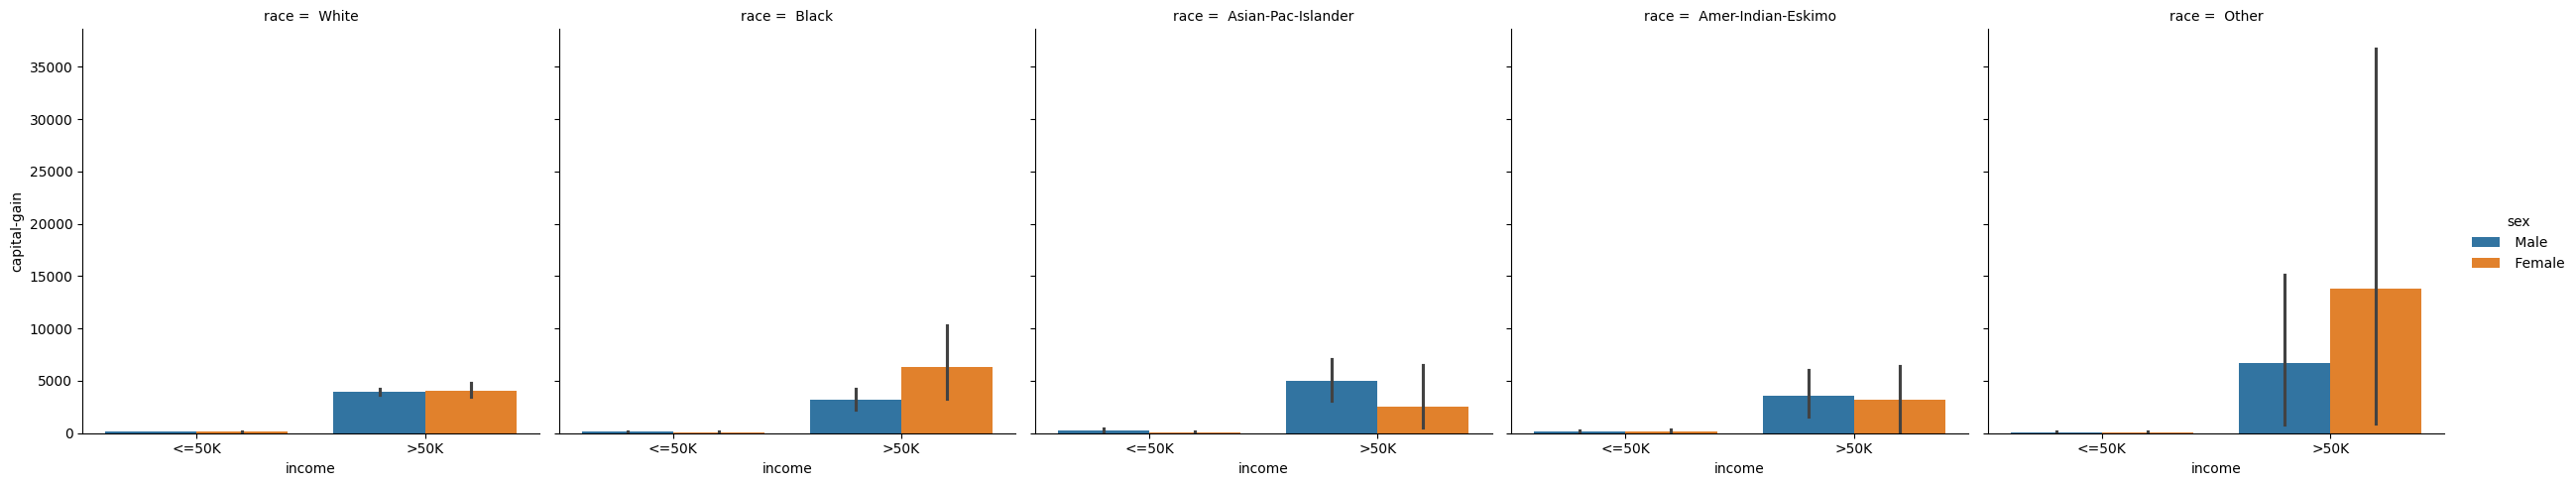

In [4]:
# Multi axes plot
sns.catplot(x='income', y='capital-gain', hue='sex', data=data, kind='bar', col='race')

As we can see from the previous multi axes plot the `Female` belonging to the `Other` race class has the higher `capital-gain` and in general `Female` has an higher `capital-gain` with respect to `Male` except for `Asian-Pac-Islander` and `Amer-Indian-Eskimo` race class.

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

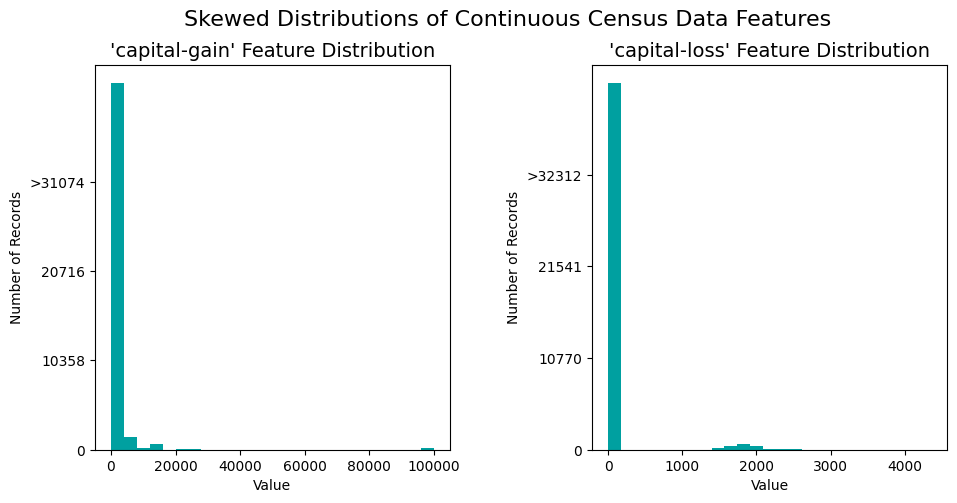

CPU times: total: 312 ms
Wall time: 318 ms


In [5]:
%%time

# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

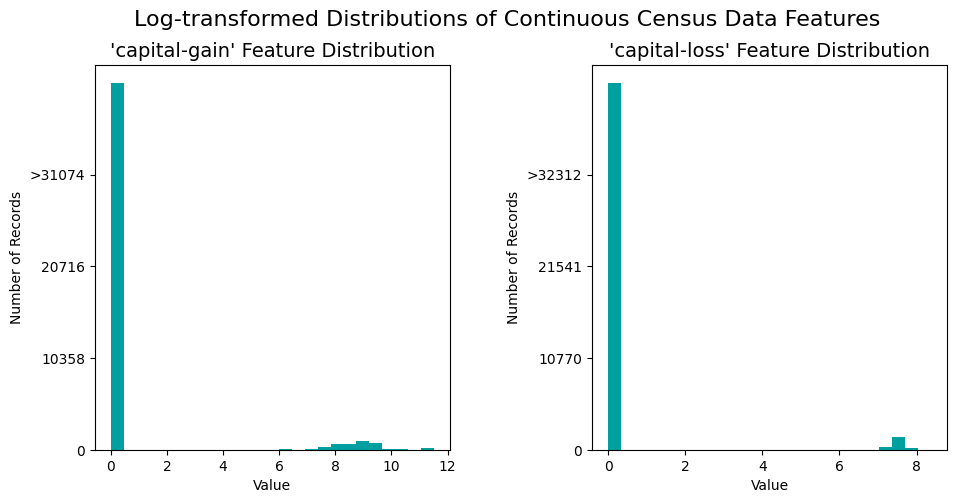

CPU times: total: 281 ms
Wall time: 270 ms


In [6]:
%%time

# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [7]:
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 10))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba
5,0.273973,Private,Masters,0.866667,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.000000,0.0,0.397959,United-States
6,0.438356,Private,9th,0.266667,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.000000,0.0,0.153061,Jamaica
7,0.479452,Self-emp-not-inc,HS-grad,0.533333,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.448980,United-States
8,0.191781,Private,Masters,0.866667,Never-married,Prof-specialty,Not-in-family,White,Female,0.829751,0.0,0.500000,United-States
9,0.342466,Private,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.742849,0.0,0.397959,United-States


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.


| Record  | someFeature |
|---------|-------------| 
|    0    |      B      |
|    1    |      C      |
|    2    |      A      |

One-hot encode:

| someFeature_A | someFeature_B | someFeature_C |
|---------------|---------------|---------------|
|       0       |       1       |       0       |
|       0       |       0       |       1       |
|       1       |       0       |       0       |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label (`<=50K` and `>50K`), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. 
In Python one-hot encoding is done with [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies).

In [8]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)
#features_final = features_final.fillna(0.0) # Not needed 
#display(features_final.head(n = 10))

# Encode the 'income_raw' data to numerical values
#display(income_raw.head(n = 10))
income = pd.DataFrame(income_raw.map({'<=50K' : 0, '>50K' : 1}), dtype = 'int64') 
#display(income.head(n = 10))
#print(income.shape[0])

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
#print(encoded)

103 total features after one-hot encoding.


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

In [9]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = conf.RANDOM_STATE)

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

#print(X_train.shape)
#print(X_test.shape)
#print(y_train.shape)
#print(y_test.shape)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Confusion Matrix, Accuracy, Precision, Recall

A **Confusion Matrix**  is a table that is often used to describe the performance of a classification model on a set of test data for which the true values are known.

|       -      |        -        |    Predicted Label   |           -          |
|--------------|-----------------|----------------------|----------------------| 
|       -      |        -        |          0           |           1          |
| Actual Label |        0        | True Negatives (TN)  | False Positives (FP) |
|       -      |        1        | False Negatives (FN) | True Positives (TP)  |

**Accuracy** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points):

`Accuracy = (True Positives + True Negative) / (True Positives + False Positives + True Negatives + False Negatives)`

**Precision** tells us what proportion of the correct prediction, actually were correct. It is a ratio of true positives to all positives, in other words it is the ratio of:

`Precision = True Positives / (True Positives + False Positives)`

**Recall (Sensitivity)** tells us what proportion of prediction that actually were correct were classified by us as correct.
It is a ratio of true positives to all the prediction that were actually positive, in other words it is the ratio of:

`Recall = True Positives / (True Positives + False Negative)`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam (including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average (harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score (we take the harmonic mean as we are dealing with ratios).

#### Naive Predictor

The the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.
As already said looking at the distribution of the data it's clear most individuals do not make more than \$50,000. Therefore a model that always predicts `'1'` (i.e. the individual makes more than 50k) will generally be right. It is also intresting to note that the naive predictor will have no **True Negatives (TN)** or **False Negatives (FN)** as we are not making any negative (`'0'` value) predictions. 
Moreover **Accuracy** in this case becomes the same as our **Precision** as every prediction that we have made with value `'1'` that should have `'0'` becomes a **False Positive (FP)** and **Recall** will becomes 1 as we have no **False Negatives (FN)**.

### Question 1 - Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? 

In [10]:
# Calculate accuracy, precision and recall

#display(income.head(n = 10))
naive_predictions = pd.DataFrame(data = np.ones(income.count()), columns = ['income'], dtype = 'int64')
#display(naive_predictions.head(n = 10))

print("Naive Predictor:\n")
      
tp =  income['income'].sum() # Counting the ones as this is the naive case

tn = 0 # No predicted negatives in the naive case

fp = len(income) - tp # Specific to the naive case

fn = 0 # No predicted negatives in the naive case

print("True positive: {}".format(tp))
print("True negative: {}".format(tn))
print("False positive: {}".format(fp))
print("False positive: {}".format(fn))

accuracy = (tp + tn) / (tp + fp + tn + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)

print("\nAccuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))

# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = (1 + conf.BETA**2)*((precision * recall)/(conf.BETA**2 * precision + recall))

# Print the results 
print("F-score: {:.4f}".format(fscore))

Naive Predictor:

True positive: 11208
True negative: 0
False positive: 34014
False positive: 0

Accuracy: 0.2478
Precision: 0.2478
Recall: 1.0000
F-score: 0.2917


The Confusion Matrix:

C:\Users\simon\AppData\Local\Temp\ipykernel_4536\3628132660.py:4: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis] # Normalize the data


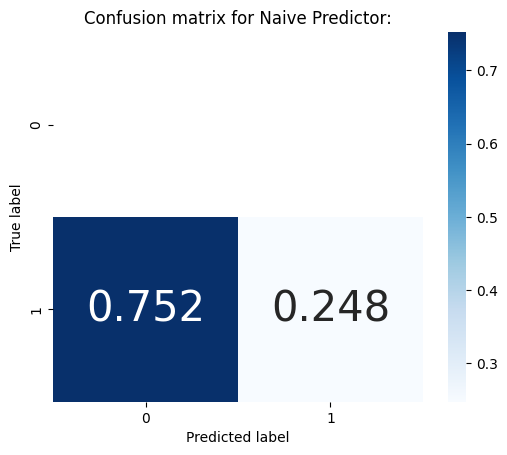

In [11]:
#Visualizing the confusion matrix

cm = confusion_matrix(naive_predictions['income'], income['income'])
cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis] # Normalize the data

vs.heatmap_confusion_matrix(cm, 'Confusion matrix for Naive Predictor:', plt_show=True)

**Answer:** The naive predictor has:
- Accuracy = 0.2478
- F-score = 0.2917

###  Supervised Learning Models
Some of the supervised learning models that are currently available in [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) and discussed in the course are:
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen

- Describe one real-world application in industry where the model can be applied. 
- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

**Answer:**

As stated by [`scikit-learn documentation`](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) choosing the right estimator fo the assigned task can be very difficult. As said in this [`Quora article`](https://www.quora.com/What-do-experienced-data-scientists-think-of-Scikit-Learns-flowchart-to-choose-the-right-estimator) there is not an exact formula to do it but the only way is to try and evaluate the results. 

- Decision Trees

  A [`decision tree`](https://en.wikipedia.org/wiki/Decision_tree) is a decision support tool that uses flowchart-like structure for decisions and their possible consequences, including chance event outcomes, resource costs, and utility. It is one way to display an algorithm that only contains conditional control statements.
 
 - Real-world application: decision trees and, in general, CART (Classification and Regression Trees) are often used in    financial analysis and recommendation systems. For example in recommendation systems they are used to recommend relevant content to users exploiting their data and feedbacks.

 - Strengths:
   - Simple to understand and interpret by humans.
   - Able to work with numerical and categorical.
 
 - Weaknesses:
   - Decision Trees can be very non-robust. A small change in the training data can result in a large change in the tree and consequently the final predictions.
   - It can create over-complex trees that do not generalize well from the training data.
 
 - Motivation to choose it: it can handle both numerical and categorical data even if the pre-processing steps we have done might already mitigate whatever advantage we would have had.


- Support Vector Machines (SVM)

  [`SVM`](https://en.wikipedia.org/wiki/Support-vector_machine) given a set of training examples, each marked as belonging to one or the other of two categories, the SVM training algorithm builds a model that assigns new examples to one category or the other, making it a non-probabilistic binary linear classifier. An SVM model is a representation of the examples as points in space, mapped so that the examples of the separate categories are divided by a clear gap that is as wide as possible. New examples are then mapped into that same space and predicted to belong to a category based on which side of the gap they fall.

 - Real-world application: SVM are used a lot in image classification and image segmentation. For example: Face detection or object detection.
 
 - Strengths:
   - Effective in high dimensional spaces, or when there are a lot of features.
   - Capable of defining complex higher order separation planes through custom kernels.
 
 - Weaknesses:
   - Requires full labeling of input data.
   - Directly applicable only for two-class tasks.
   - Time consuming on large datasets.
 
 - Motivation to choose it: SVM is a good candidate for our task because we have not to much data (`<100K samples`) in fact SVC can be slow to train on large dataset and also because we are dealing with a two-class task (The 'income' feature we want to predict has only two possible categories (<=50K and >50K) we can apply SVM directly.
 
 
- Ensemble Methods: AdaBoost

  [`AdaBoost`](https://en.wikipedia.org/wiki/AdaBoost), short for Adaptive Boosting, is a machine learning meta-algorithm that can be used in conjunction with many other types of learning algorithms to improve performance. The output of the other learning algorithms called 'weak learners' (e.g. decision trees) is combined into a weighted sum that represents the final output of the boosted classifier. AdaBoost is adaptive in the sense that subsequent weak learners are tweaked in favor of those instances misclassified by previous classifiers. The individual learners can be weak, but as long as the performance of each one is slightly better than random guessing, the final model can be proven to converge to a strong learner.
 
 - Real-world application: It is extensively used in object detection.
   
 - Strengths:
   - Ensemble methods, including Adaboost are more robust than single estimators, have improved generalizability.
   - Robust to overfitting.
  
 - Weaknesses:
   - Sensitive to noisy data and outliers.
   - If the weak learners are biased also the resulting boosted model will be biased.
  
 - Motivation to choose it: in general ensemble methods are high quality classifiers because they combine many weak classifier for final prediction. AdaBoost can learn non-linear decision boundaries and is pretty fast to train.

----
## Implementation
To properly evaluate the performance of each model we have chosen, it's important that we create a training and predicting pipeline that allows us to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. 

### Creating a Training and Predicting Pipeline
First we will implement a function `train_predict(learner, sample_size, X_train, y_train, X_test, y_test)` which take in input:
- learner: the learning algorithm to be trained and predicted on
- sample_size: the size of samples (number) to be drawn from training set
- X_train: features training set
- y_train: income training set
- X_test: features testing set
- y_test: income testing set

and perfomr this steps:

- Fit the learner to the sampled training data and record the training time.
- Perform predictions on the test data `X_test`, and also on the first `300` training points `X_train[:300]`.
- Record the total prediction time.
- Calculate the accuracy score and F-score for both the training subset and testing set. To do this we will use `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).

In [12]:
# Import two metrics from sklearn - fbeta_score and accuracy_score

from sklearn.metrics import accuracy_score, fbeta_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
	'''
	Train a classifier and use it to predict

	Parameters:
		learner: The learning algorithm to be trained and predicted on
		sample_size: The size of samples (number) to be drawn from training set
		X_train: Features training set
		y_train: Income training set
		X_test: Features testing set
		y_test: Income testing set

	Returns:
		results: Results
	'''

	results = {}

	# Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
	start = time() # Get start time
	learner.fit(X_train[:sample_size], y_train[:sample_size])
	end = time() # Get end time

	# Calculate the training time
	results['train_time'] = end - start

	sample_size_training = 300
		
	# Get the predictions on the test set(X_test), then get predictions on the first 300 training samples(X_train) 
	# using .predict()
	start = time() # Get start time
	predictions_test = learner.predict(X_test)
	predictions_train = learner.predict(X_train[:sample_size_training])
	end = time() # Get end time

	# Calculate the total prediction time
	results['pred_time'] = end - start
			
	# Compute accuracy on the first 300 training samples which is y_train[:300]
	results['acc_train'] = accuracy_score(y_train[:sample_size_training], predictions_train)
		
	# Compute accuracy on test set using accuracy_score()
	results['acc_test'] = accuracy_score(y_test, predictions_test)

	# Compute F-score on the the first 300 training samples using fbeta_score()
	results['f_train'] = fbeta_score(y_train[:sample_size_training], predictions_train, beta=conf.BETA)
		
	# Compute F-score on the test set which is y_test
	results['f_test'] = fbeta_score(y_test, predictions_test, beta=conf.BETA)
		
	print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
		
	# Return the results
	return results

### Initial Model Evaluation
Now we will:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'classifier_A'`, `'classifier_B'`, and `'classifier_C'`.
  - Use a `'random_state'` for each model you use, if provided and use the default settings for each model. We will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

In [13]:
# Import the three supervised learning models from sklearn

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

# Initialize the three models
classifier_A = DecisionTreeClassifier(random_state = conf.RANDOM_STATE)
classifier_B = SVC(random_state = conf.RANDOM_STATE, gamma='auto')
classifier_C = AdaBoostClassifier(random_state = conf.RANDOM_STATE, algorithm='SAMME')  # Explicitly setting the algorithm to SAMME to avoid FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(y_train)
samples_10 = int(len(y_train) * (10 / 100))
samples_1 = int(len(y_train) * (1 / 100))

#print(samples_100)
#print(samples_10)
#print(samples_1)

# Collect results on the learners
results = {}
for classifier in [classifier_A, classifier_B, classifier_C]:
    classifier_name = classifier.__class__.__name__
    results[classifier_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[classifier_name][i] = \
        train_predict(classifier, samples, X_train, y_train, X_test, y_test)

DecisionTreeClassifier trained on 361 samples.
DecisionTreeClassifier trained on 3617 samples.
DecisionTreeClassifier trained on 36177 samples.
SVC trained on 361 samples.
SVC trained on 3617 samples.
SVC trained on 36177 samples.


c:\Users\simon\source\repos\my_projects\udacity\data_scientist_nanodegree\core_curriculum\term_1\supervised_learning\finding_donors_project\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


AdaBoostClassifier trained on 361 samples.


c:\Users\simon\source\repos\my_projects\udacity\data_scientist_nanodegree\core_curriculum\term_1\supervised_learning\finding_donors_project\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


AdaBoostClassifier trained on 3617 samples.


c:\Users\simon\source\repos\my_projects\udacity\data_scientist_nanodegree\core_curriculum\term_1\supervised_learning\finding_donors_project\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


AdaBoostClassifier trained on 36177 samples.


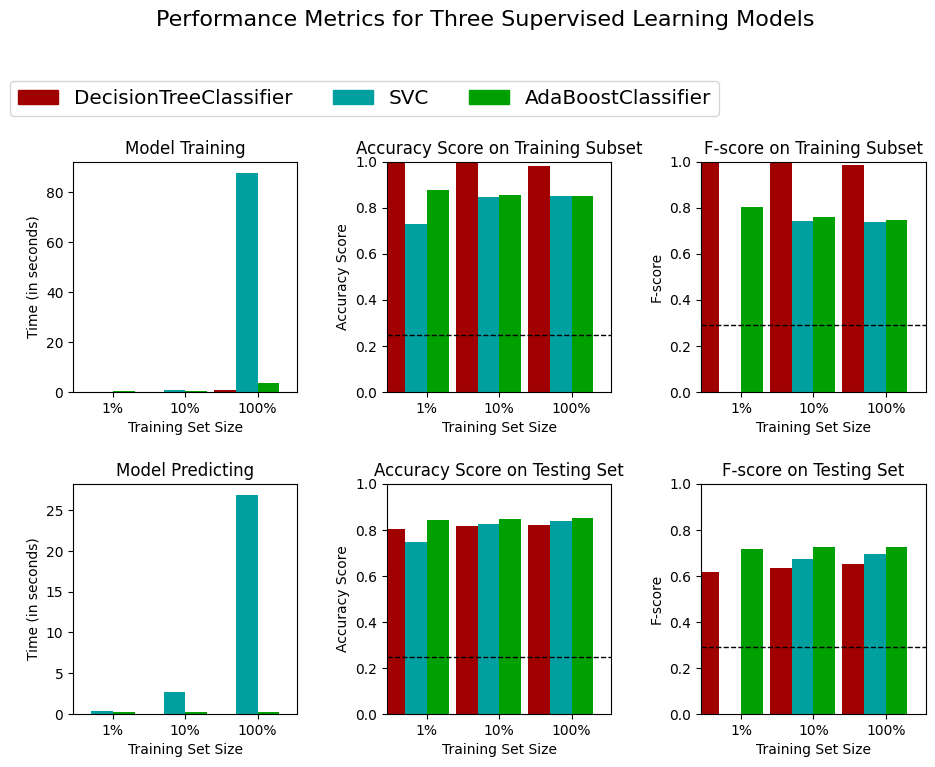

In [14]:
# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

The `FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning` warning indicates that the SAMME.R algorithm will no longer be the default in a future version of scikit-learn. This warning is often encountered when using AdaBoostClassifier without explicitly specifying the algorithm parameter.
To address this warning, you should explicitly set the algorithm parameter when initializing AdaBoostClassifier. You can choose between:

- SAMME: Discrete AdaBoost algorithm. It uses a weighted majority vote to combine the weak classifiers.
- SAMME.R: Real AdaBoost algorithm. It uses a weighted sum of the weak classifiers' predictions (probability estimates) to make the final prediction. This is often more accurate and is the current default.

It is usefull to see the results more in detail:

In [15]:
#Printing out the values
for i in results.items():
    print(i[0])
    display(pd.DataFrame(i[1]).rename(columns={0:'1%', 1:'10%', 2:'100%'}))

DecisionTreeClassifier


,1%,10%,100%
train_time,0.009946,0.049780,0.500690
pred_time,0.010057,0.000000,0.009332
acc_train,1.000000,0.996667,0.980000
acc_test,0.803980,0.814151,0.821338
f_train,1.000000,0.997506,0.984252
f_test,0.614399,0.634857,0.649132


SVC


,1%,10%,100%
train_time,0.000000,0.530235,87.650331
pred_time,0.289835,2.639768,26.929737
acc_train,0.730000,0.846667,0.850000
acc_test,0.745716,0.825207,0.837369
f_train,0.000000,0.744337,0.739130
f_test,0.000000,0.670825,0.695181


AdaBoostClassifier


,1%,10%,100%
train_time,0.129841,0.475186,3.392184
pred_time,0.190091,0.207422,0.208077
acc_train,0.876667,0.856667,0.850000
acc_test,0.843560,0.846656,0.850083
f_train,0.801187,0.759878,0.744681
f_test,0.714949,0.722801,0.725490


The confusione matrix for each model:

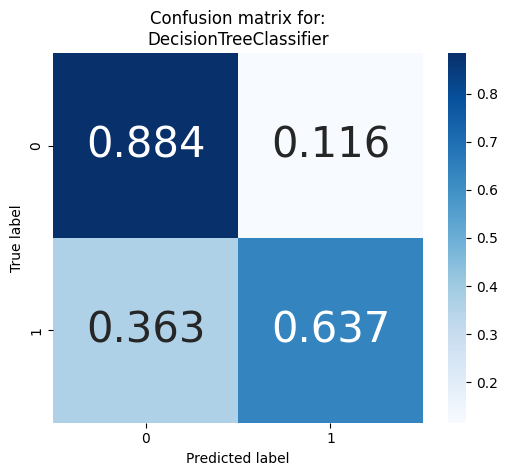

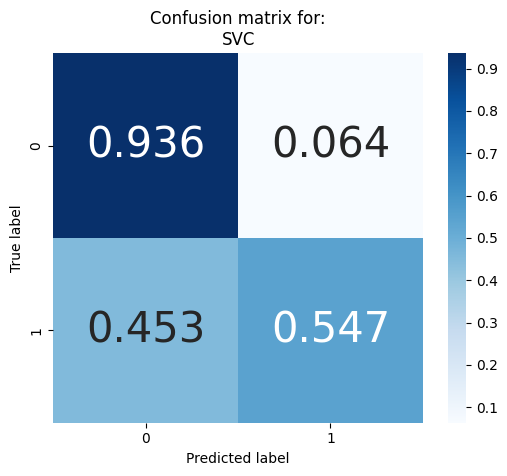

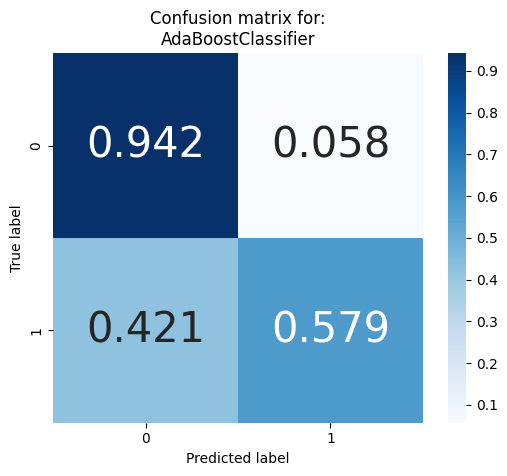

In [16]:
# Visualizing the confusion matrix for each classifier

for i,model in enumerate([classifier_A, classifier_B, classifier_C]):
	cm = confusion_matrix(y_test, model.predict(X_test))
	cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis] # Normalize the data

	# plt_show only at the last one
	if i == 2:
		plt_show = True
	else:
		plt_show = False
	
	vs.heatmap_confusion_matrix(cm, 'Confusion matrix for:\n{}'.format(model.__class__.__name__), plt_show=plt_show)

As already said we are focusing on the model's ability to precisely predict those that make more than $50,000 which is more important than the model's ability to recall those individuals. **AdaBoostClassifier** is the one that performs best on the testing data, in terms of both the `Accuracy` and `F-score`. Moreover **AdaBoostClassifier** is also pretty fast to train as shown int the Time-Training_set_size histogram.

----
## Improving the results
In this final section, we will choose from the three supervised learning models the *best* model to use on the data. We will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's `F-score`. 

### Question 3 - Choosing the Best Model

Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000? Please discussion:
* metrics - F score on the testing when 100% of the training data is used
* prediction/training time
* the algorithm's suitability for the data

**Answer:** Looking at the graph at the bottom left from the cell above (the visualization created by `vs.evaluate(results, accuracy, fscore)`) and also in the detailed results cell we can see that AdaBoost outperfoms both the decision tree and SVC for F-score and accuracy for the testing set. We can also see that the decision tree overfit the training dataset so it performs poorly on the testing set. For the point of view of the prediction/training time the decision tree is the fastest and the SVM is by far the slowest. This is motivated by the fact that by default, [`AdaBoostClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) uses `DecisionTreeClassifier(max_depth = 1)` as its weak learners, which can handle categorical and numerical data and are relatively faster to train. To confirm that AdaBoost is the model with the best performance we can also compare its confusion matrix with the confusion matrix of the other models.  

### Question 4 - Describing the Model in Layman's Terms

In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical jargon, such as describing equations.

**Answer:** Given the hypothesis that a person earnig more than \$50,000 per year is more likely a potential new donor for *CharityML* we have trained a model with the census information of individuals that can predict if a person makes  more than \$50,000 per year. In this way we can use this prediction to understand if it is a good idea to contact a new potential donor beacause he will likely donate to the charity. The model with the best performances in the ones selected is Adaboost, which is an ensemble model, thus it is based on the idea that combining simple models called "weak learners" (i.e. letting them vote for the final answer) we can build a more complex one. The algorithm strat by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases. The training iteration are repeated for a number of iterations defined by the user in an attempt to find the set of weighted hypotheses that combined will perform best on the data. The cool thing about Adaboost is that is fast to train because we can use "weak learners" which perform slightly better than random guessing and obtain a final model with very good perfomances.

### Model Tuning
Now we will fine tune the chosen model. As already said we will sse grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. We will need to use the entire training set for this. 

Using [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) we are going to:
- Initialize the classifier you've chosen and store it in `classifier`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model: `parameters = {'parameter' : [list of values]}`. 
 - Example: `parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}`.
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `classifier` using the `'scorer'`, and store it in `grid_object`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

c:\Users\simon\source\repos\my_projects\udacity\data_scientist_nanodegree\core_curriculum\term_1\supervised_learning\finding_donors_project\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
c:\Users\simon\source\repos\my_projects\udacity\data_scientist_nanodegree\core_curriculum\term_1\supervised_learning\finding_donors_project\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
c:\Users\simon\source\repos\my_projects\udacity\data_scientist_nanodegree\core_curriculum\term_1\supervised_learning\finding_donors_project\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.


Unoptimized model
Accuracy score on testing data: 0.8501
F-score on testing data: 0.7255

----------
Optimized Model
Final accuracy score on the testing data: 0.8505
Final F-score on the testing data: 0.7332

----------
Best Model

AdaBoostClassifier(algorithm='SAMME', learning_rate=0.5, n_estimators=120,
                   random_state=42)


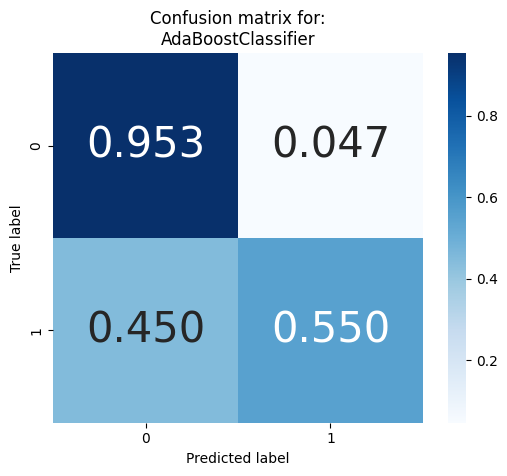

In [17]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Initialize the classifier
classifier = AdaBoostClassifier(random_state = conf.RANDOM_STATE, algorithm='SAMME')

# Create the parameters list you wish to tune, using a dictionary if needed.
parameters = {'n_estimators':[50, 120], 
              'learning_rate':[0.1, 0.5, 1.]
             }

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta = conf.BETA)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_object = GridSearchCV(estimator=classifier, param_grid=parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_object.fit(X_train,y_train)

# Get the estimator
best_classifier = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (classifier.fit(X_train, y_train)).predict(X_test)
best_predictions = best_classifier.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = conf.BETA)))
print("\n----------\nOptimized Model")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = conf.BETA)))
print("\n----------\nBest Model\n")
print(best_classifier)

# Confusion Matrix
cm = confusion_matrix(y_test, best_predictions)
cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis] # Normalize the data

vs.heatmap_confusion_matrix(cm, 'Confusion matrix for:\n{}'.format(model.__class__.__name__), plt_show=True)

### Question 5 - Final Model Evaluation

* What is your optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 
* How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**? 

#### Results:

|     Metric     |    Naive model    | Unoptimized Model | Optimized Model |
|----------------|-------------------|-------------------|-----------------|
| Accuracy Score |       0.2478      |       0.8566      |      0.8588     |
| F-score        |       0.2917      |       0.7313      |      0.7357     |

**Answer:**
The optimized model has:
- Accuracy = 0.8588 
- F-score = 0.7357

These scores are better than the umpotimized model and way better than the naive predictor.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Some scikit-learn classifier (e.g., adaboost, random forests) has a `feature_importances_` attribute, which is a function that ranks the importance of features when making predictions based on the chosen classifier.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?

**Answer:**

Considering all the feature:
- age
- workclass
- education_level
- education-num
- marital-status
- occupation
- relationship
- race
- sex
- capital-gain
- capital-loss
- hours-per-week
- native-country

the five more important featurs related to the income of a person could be guessed as:
- education: people with higher education are reasonably more likely to have an higher income.
- occupation: of course the income of a person depends on his job.
- age: usually younger people earn less money because he can assume they do not have a lot of experience in their position.
- marital-status: in general someone whom is married is reasonably older thus should have a senior job position which shuold be payed more.
- hours-per-week: bacisally the more hours someone works and higher his income should be.

### Extracting Feature Importance
Now we will:
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

c:\Users\simon\source\repos\my_projects\udacity\data_scientist_nanodegree\core_curriculum\term_1\supervised_learning\finding_donors_project\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


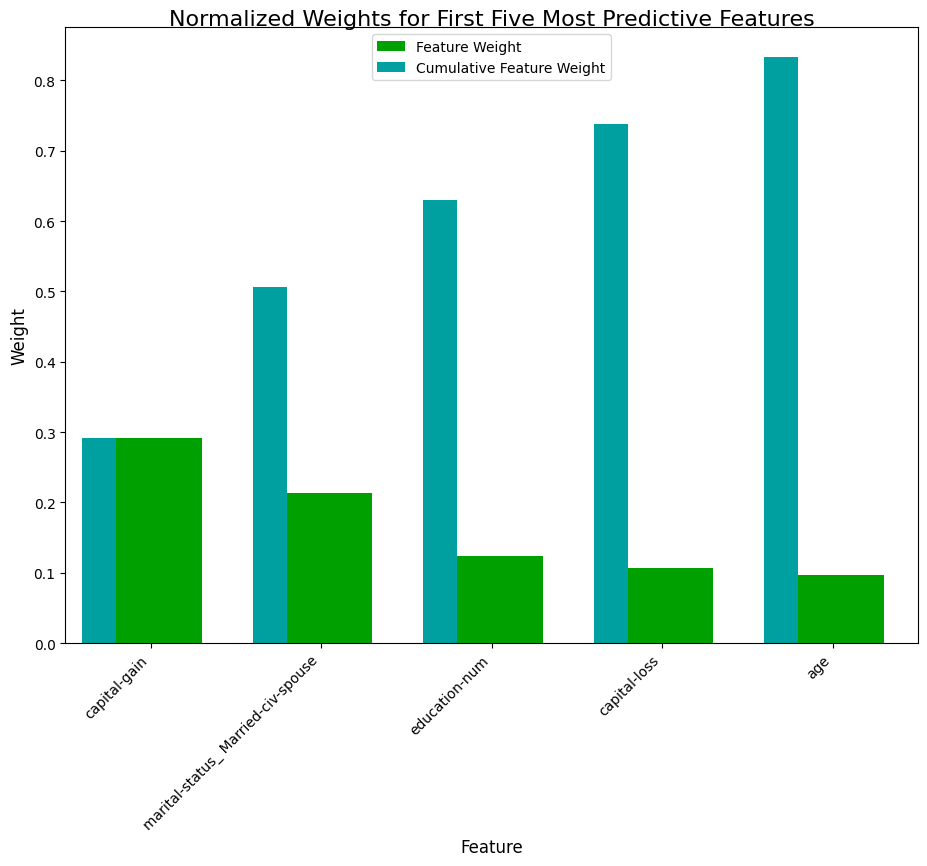

In [18]:
# Import a supervised learning model that has 'feature_importances_'

# Train the supervised model on the training set using .fit(X_train, y_train)
model = AdaBoostClassifier(algorithm='SAMME').fit(X_train,y_train)

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
* How do these five features compare to the five features you discussed in **Question 6**?
* If you were close to the same answer, how does this visualization confirm your thoughts? 
* If you were not close, why do you think these features are more relevant?

**Answer:**

The five most relevant feature extracted from the data are:
- capital-gain
- age
- capital-loss
- hours-per-week
- education-num

Previously we haven't considered `capital-loss` and `capital-gain` but it is reasonable that the income is related to the people profit or loss from the sale of assets/property. Surprisingly the `occupation` is not mentioned in the most important features and the `edication-num` is the last one picked in order of importance.

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. Now we will use the same optimized model we found earlier, and train it on the same training set *with only the top five important features*. 

c:\Users\simon\source\repos\my_projects\udacity\data_scientist_nanodegree\core_curriculum\term_1\supervised_learning\finding_donors_project\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Final Model trained on full data

Accuracy on testing data: 0.8505
F-score on testing data: 0.7332

----------
Final Model trained on reduced data

Accuracy on testing data: 0.8462
F-score on testing data: 0.7222


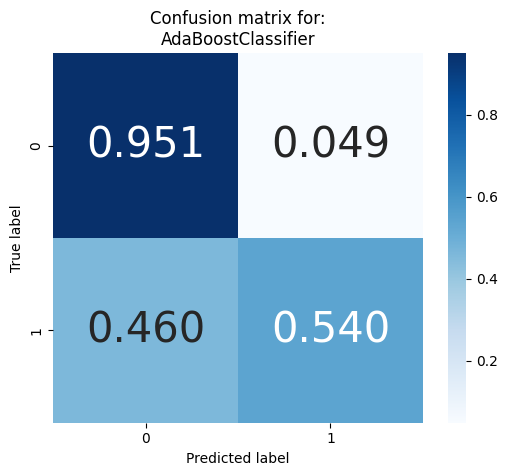

In [19]:
# Import functionality for cloning a model
from sklearn.base import clone

n_top_important_features = 5

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:n_top_important_features]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:n_top_important_features]]]

#print(X_train_reduced.shape)
#print(X_test_reduced.shape)

# Display the first 10 records
#display(X_train_reduced.head(n=10))

# Train on the "best" model found from grid search earlier
classifier = (clone(best_classifier)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = classifier.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = conf.BETA)))
print("\n----------\nFinal Model trained on reduced data\n")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = conf.BETA)))

# Confusion Matrix
cm = confusion_matrix(y_test, reduced_predictions)
cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis] # Normalize the data

vs.heatmap_confusion_matrix(cm, 'Confusion matrix for:\n{}'.format(model.__class__.__name__), plt_show=True)

### Question 8 - Effects of Feature Selection

* How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?
* If training time was a factor, would you consider using the reduced data as your training set?

**Answer:**

Using the reduced dataset both Accuracy and F-score are lower with respect to the values obtained using all the features. Accuracy is 3.51% lower and F-score is 8.62% lower but reasonably training on less data means that also the training time is lower. We can conclude that if the training time is a discriminating factor for any reason (e.g. huge amount of training data), even if AdaBoost is relatively fast, using only the most important features could be a solution to the problem because it is faster and does not have a big impact on the predictive performances.